In [105]:
#!apt -q install libomp-dev
# !pip -q install faiss-gpu
!pip -q install faiss-cpu
!pip -q install phik

In [109]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from phik.report import plot_correlation_matrix
from phik import report

In [23]:
df_path = 'data/match/'

In [37]:
if os.path.exists(df_path):
    df_base = pd.read_csv(df_path+'base.csv')
    df_train = pd.read_csv(df_path+'train.csv')
    df_validation = pd.read_csv(df_path+'validation.csv')
    df_validation_answer = pd.read_csv(df_path+'validation_answer.csv')
else:
    print('Something is wrong')

In [41]:
def primary_information(df):
    """Вывод общей информации о датасете"""
    print(f"Размерность: {df.shape}")
    display(df.info())
    display(df.head())

In [43]:
def pass_value_barh(df):
    """Вывод графика с количеством пропущенных значений"""
    try:
        ax = (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
        )
        ax.set_xlabel("Пропущенные значения, %", fontsize = 16, color = 'SteelBlue')
        ax.set_ylabel("Поле", fontsize = 16, color = 'SteelBlue')
        ax.set_title('Процент пропущенных значений' + "\n", fontsize = 22, color = 'SteelBlue')
    except:
        print('Пропусков нет')

In [63]:
print(f"Датесет df_base")
primary_information(df_base)
print(f"Датесет df_train")
primary_information(df_train)
print(f"Датесет df_validation")
primary_information(df_validation)
print(f"Датесет df_validation_answer")
primary_information(df_validation_answer)

Датесет df_base
Размерность: (280535, 73)
<class 'pandas.core.frame.DataFrame'>
Index: 280535 entries, 0 to 291812
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      280535 non-null  object 
 1   0       280535 non-null  float64
 2   1       280535 non-null  float64
 3   2       280535 non-null  float64
 4   3       280535 non-null  float64
 5   4       280535 non-null  float64
 6   5       280535 non-null  float64
 7   6       280535 non-null  float64
 8   7       280535 non-null  float64
 9   8       280535 non-null  float64
 10  9       280535 non-null  float64
 11  10      280535 non-null  float64
 12  11      280535 non-null  float64
 13  12      280535 non-null  float64
 14  13      280535 non-null  float64
 15  14      280535 non-null  float64
 16  15      280535 non-null  float64
 17  16      280535 non-null  float64
 18  17      280535 non-null  float64
 19  18      280535 non-null  float64
 20  19      280

None

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,4207931-base,-43.946243,15.364378,17.515854,-132.31146,157.064420,-4.069252,-340.630860,-57.550140,128.398220,...,-71.927170,30.711966,-90.190475,-24.931271,66.972534,106.346634,-44.270622,155.98834,-1074.464888,-25.066608
1,2710972-base,-73.004890,4.923342,-19.750746,-136.52908,99.907170,-70.709110,-567.401996,-128.890150,109.914986,...,-109.044660,20.916021,-171.201390,-110.596844,67.730100,8.909615,-9.470253,133.29536,-545.897014,-72.913230
2,1371460-base,-85.565570,-0.493598,-48.374817,-157.98502,96.809510,-81.710210,-22.297688,79.768670,124.357086,...,-58.821650,41.369606,-132.934500,-43.016839,67.871925,141.778240,69.048520,111.72038,-1111.038833,-23.087206
3,3438601-base,-105.564090,15.393871,-46.223934,-158.11488,79.514114,-48.944480,-93.713010,38.581398,123.397960,...,-87.907290,-58.806870,-147.794800,-155.830237,68.974754,21.397510,126.098785,139.73320,-1282.707248,-74.527940
4,422798-base,-74.638880,11.315012,-40.204174,-161.76430,50.507114,-80.775560,-640.923467,65.225000,122.344940,...,-30.002094,53.642930,-149.823230,176.921371,69.473280,-43.395180,-58.947716,133.84064,-1074.464888,-1.164146


Датесет df_train
Размерность: (9999, 74)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 74 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      9999 non-null   object 
 1   0       9999 non-null   float64
 2   1       9999 non-null   float64
 3   2       9999 non-null   float64
 4   3       9999 non-null   float64
 5   4       9999 non-null   float64
 6   5       9999 non-null   float64
 7   6       9999 non-null   float64
 8   7       9999 non-null   float64
 9   8       9999 non-null   float64
 10  9       9999 non-null   float64
 11  10      9999 non-null   float64
 12  11      9999 non-null   float64
 13  12      9999 non-null   float64
 14  13      9999 non-null   float64
 15  14      9999 non-null   float64
 16  15      9999 non-null   float64
 17  16      9999 non-null   float64
 18  17      9999 non-null   float64
 19  18      9999 non-null   float64
 20  19      9999 non-null   float64
 

None

,Id,0,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,Target
0,109249-query,-24.021454,3.122524,-80.947525,-112.329994,191.090180,-66.903130,-759.626065,-75.284454,120.55149,...,-24.601670,-167.760770,133.678516,68.184600,26.317545,11.938202,148.549320,-778.563381,-46.877750,66971-base
1,34137-query,-82.033580,8.115866,-8.793022,-182.972100,56.645336,-52.597610,-55.720337,130.059250,129.38335,...,54.448433,-120.894806,-12.292085,66.608116,-27.997612,10.091335,95.809265,-1022.691531,-88.564705,1433819-base
2,136121-query,-75.719640,-0.223386,-86.186130,-162.064060,114.320114,-53.394600,-117.261013,-24.857851,124.80780,...,-5.609123,-93.029880,-80.997871,63.733383,11.378683,62.932007,130.975390,-1074.464888,-74.861176,290133-base
3,105191-query,-56.580620,5.093593,-46.943110,-149.039120,112.436430,-76.820510,-324.995645,-32.833107,119.47865,...,21.624313,-158.880370,179.597294,69.891360,-33.804955,233.914610,122.868546,-1074.464888,-93.775375,1270048-base
4,63983-query,-52.725650,9.027046,-92.829650,-113.111010,134.124970,-42.423073,-759.626065,8.261169,119.49023,...,13.807772,-208.650040,41.742014,66.522420,41.362930,162.723050,111.261310,-151.162805,-33.831450,168591-base


Датесет df_validation
Размерность: (10000, 73)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 73 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      10000 non-null  object 
 1   0       10000 non-null  float64
 2   1       10000 non-null  float64
 3   2       10000 non-null  float64
 4   3       10000 non-null  float64
 5   4       10000 non-null  float64
 6   5       10000 non-null  float64
 7   6       10000 non-null  float64
 8   7       10000 non-null  float64
 9   8       10000 non-null  float64
 10  9       10000 non-null  float64
 11  10      10000 non-null  float64
 12  11      10000 non-null  float64
 13  12      10000 non-null  float64
 14  13      10000 non-null  float64
 15  14      10000 non-null  float64
 16  15      10000 non-null  float64
 17  16      10000 non-null  float64
 18  17      10000 non-null  float64
 19  18      10000 non-null  float64
 20  19      10000 non-null  fl

None

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,196680-query,-59.383420,8.563436,-28.203072,-134.22534,82.73661,-150.572170,-129.178969,23.670555,125.66636,...,-103.481630,79.564530,-120.31357,54.218155,68.50073,32.681908,84.19686,136.412960,-1074.464888,-21.233612
1,134615-query,-103.912150,9.742726,-15.209915,-116.37310,137.69880,-85.530075,-776.123158,44.481530,114.67121,...,-51.193770,49.299644,-101.89454,105.560548,67.80104,13.633057,108.05138,111.864456,-841.022331,-76.567980
2,82675-query,-117.923280,-3.504554,-64.299390,-155.18713,156.82137,-34.082264,-537.423653,54.078613,121.97396,...,-115.176155,48.636130,-132.17967,-0.988696,68.11125,107.065216,134.61765,134.080000,27.773269,-32.401714
3,162076-query,-90.880554,4.888542,-39.647797,-131.75010,62.36212,-105.593270,-347.132493,-83.351750,133.91331,...,-112.293790,54.884007,-177.56935,-116.374997,67.88766,136.893980,124.89447,117.707750,-566.343980,-90.905556
4,23069-query,-66.946740,10.562773,-73.781830,-149.39787,2.93866,-51.288853,-587.189361,-2.764402,126.56105,...,-116.440605,47.279976,-162.65400,107.409409,67.78526,-60.976490,142.68571,82.264300,-345.340457,-48.572525


Датесет df_validation_answer
Размерность: (10000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        10000 non-null  object
 1   Expected  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


None

,Id,Expected
0,196680-query,1087368-base
1,134615-query,849674-base
2,82675-query,4183486-base
3,162076-query,2879258-base
4,23069-query,615229-base


In [61]:
df_base.duplicated().sum()

0

In [59]:
df_base = df_base.drop_duplicates()

In [97]:
def draw_boxplots(df, ncols, nrows, title):
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16, 32))
    i = 0
    for column in df.columns:
        if column == 'Id':
            continue
        sns.boxplot(data = df, y=column, ax=axs[i % nrows][i // nrows])
        axs[i % nrows][i // nrows].set_xlabel(column)
        axs[i % nrows][i // nrows].set_ylabel("")
        i += 1
    fig.suptitle(title, fontsize=30);

In [107]:
def draw_hists(df, ncols, nrows, title):
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16, 32))
    i = 0
    for column in df.columns:
        if column == 'Id':
            continue
        df[column].hist(ax=axs[i % nrows][i // nrows])
        axs[i % nrows][i // nrows].set_xlabel(column)
        axs[i % nrows][i // nrows].set_ylabel("")
        i += 1
    fig.suptitle(title, fontsize=30);

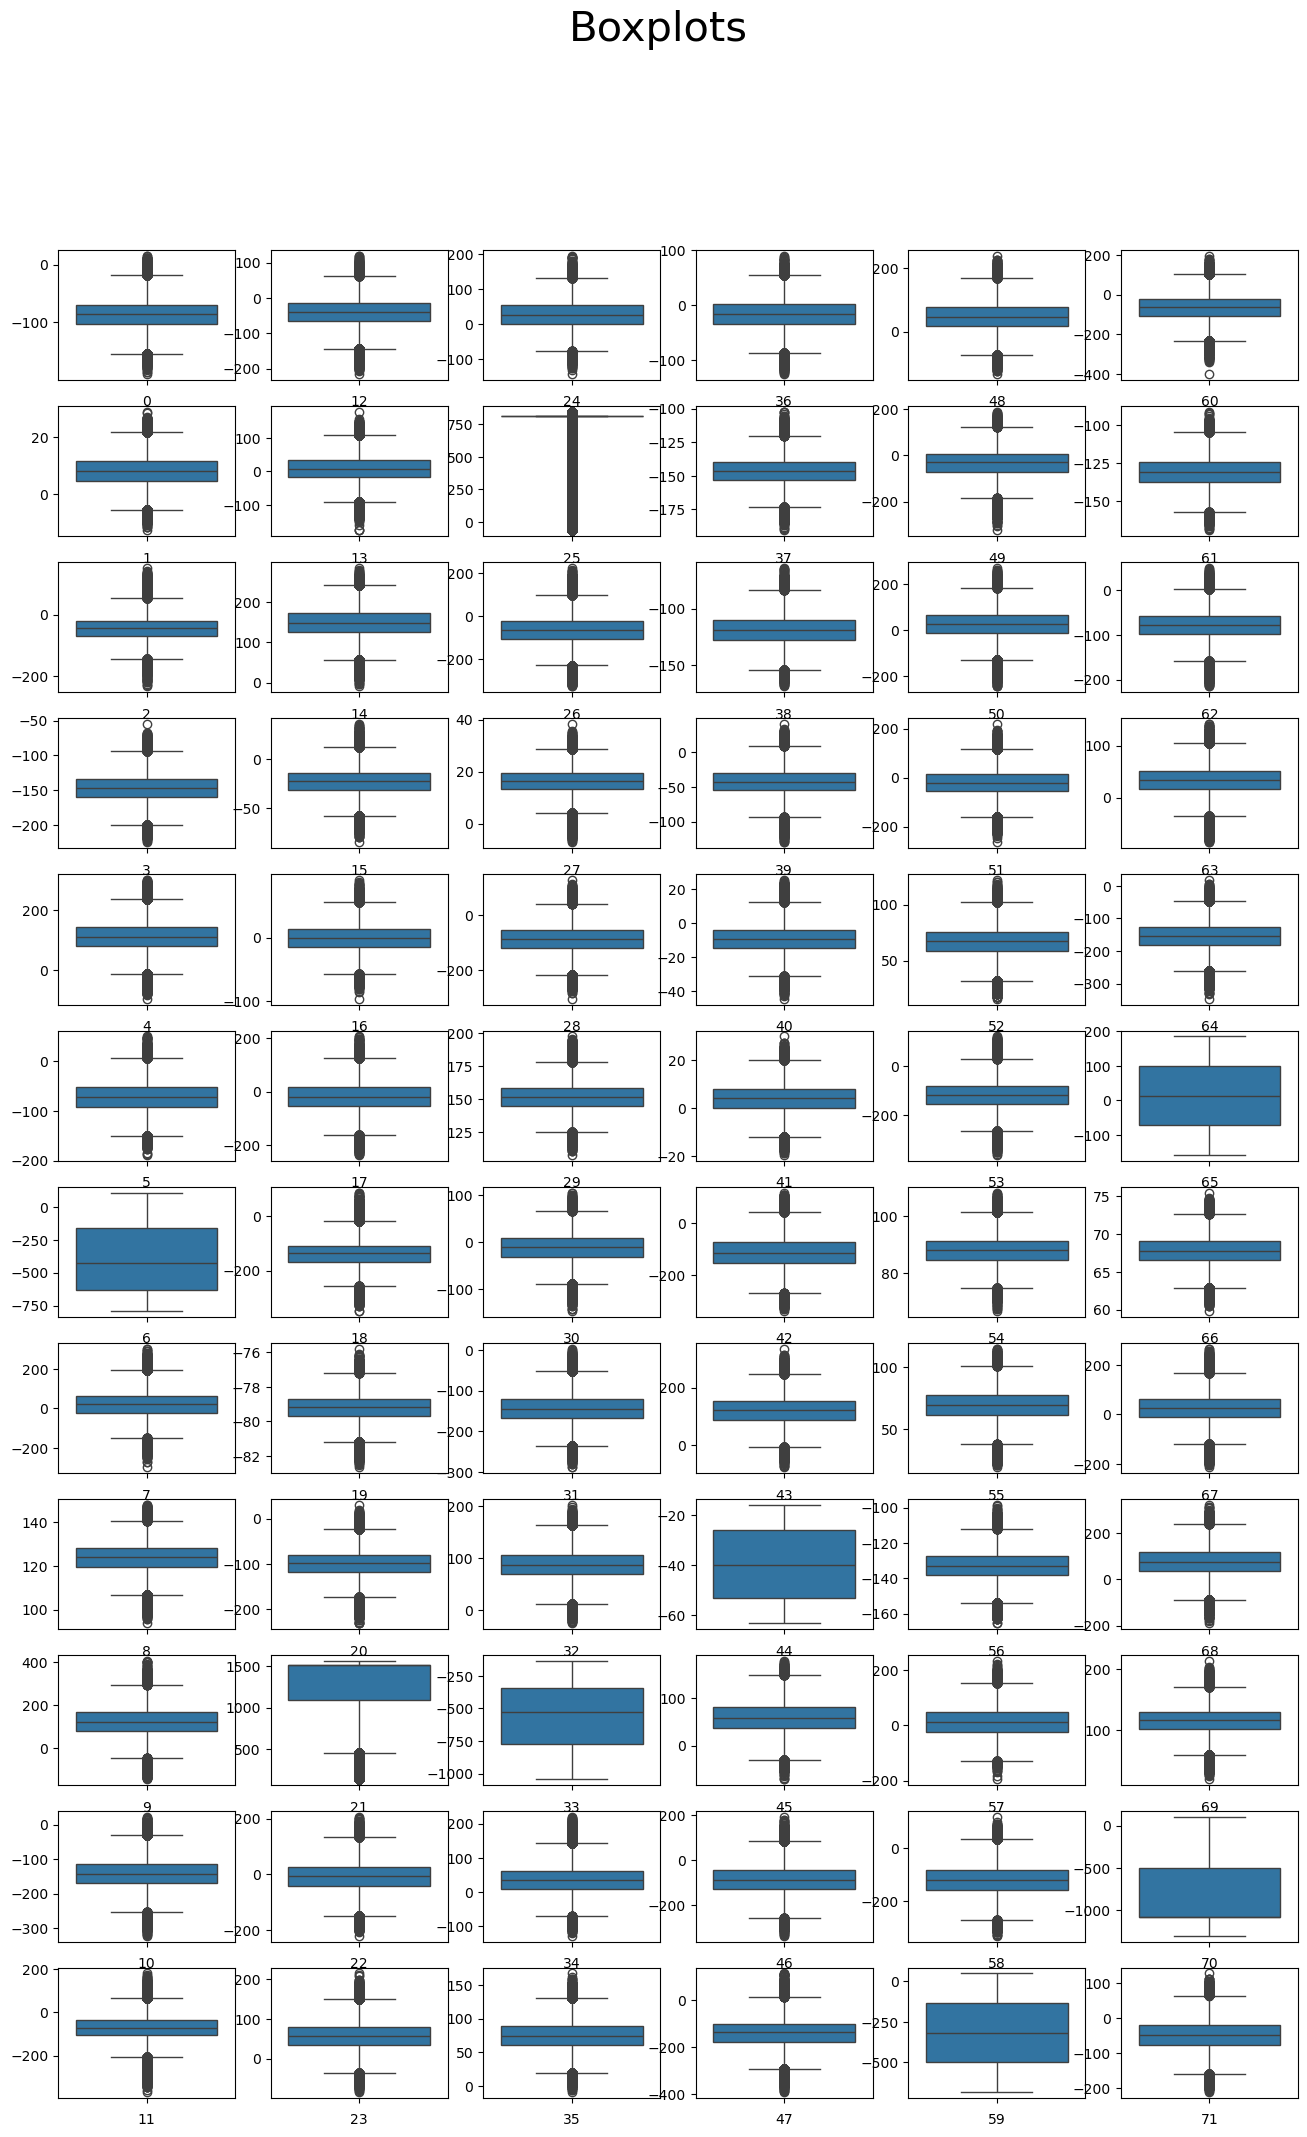

In [99]:
draw_boxplots(df_base, 6, 12, "Boxplots")

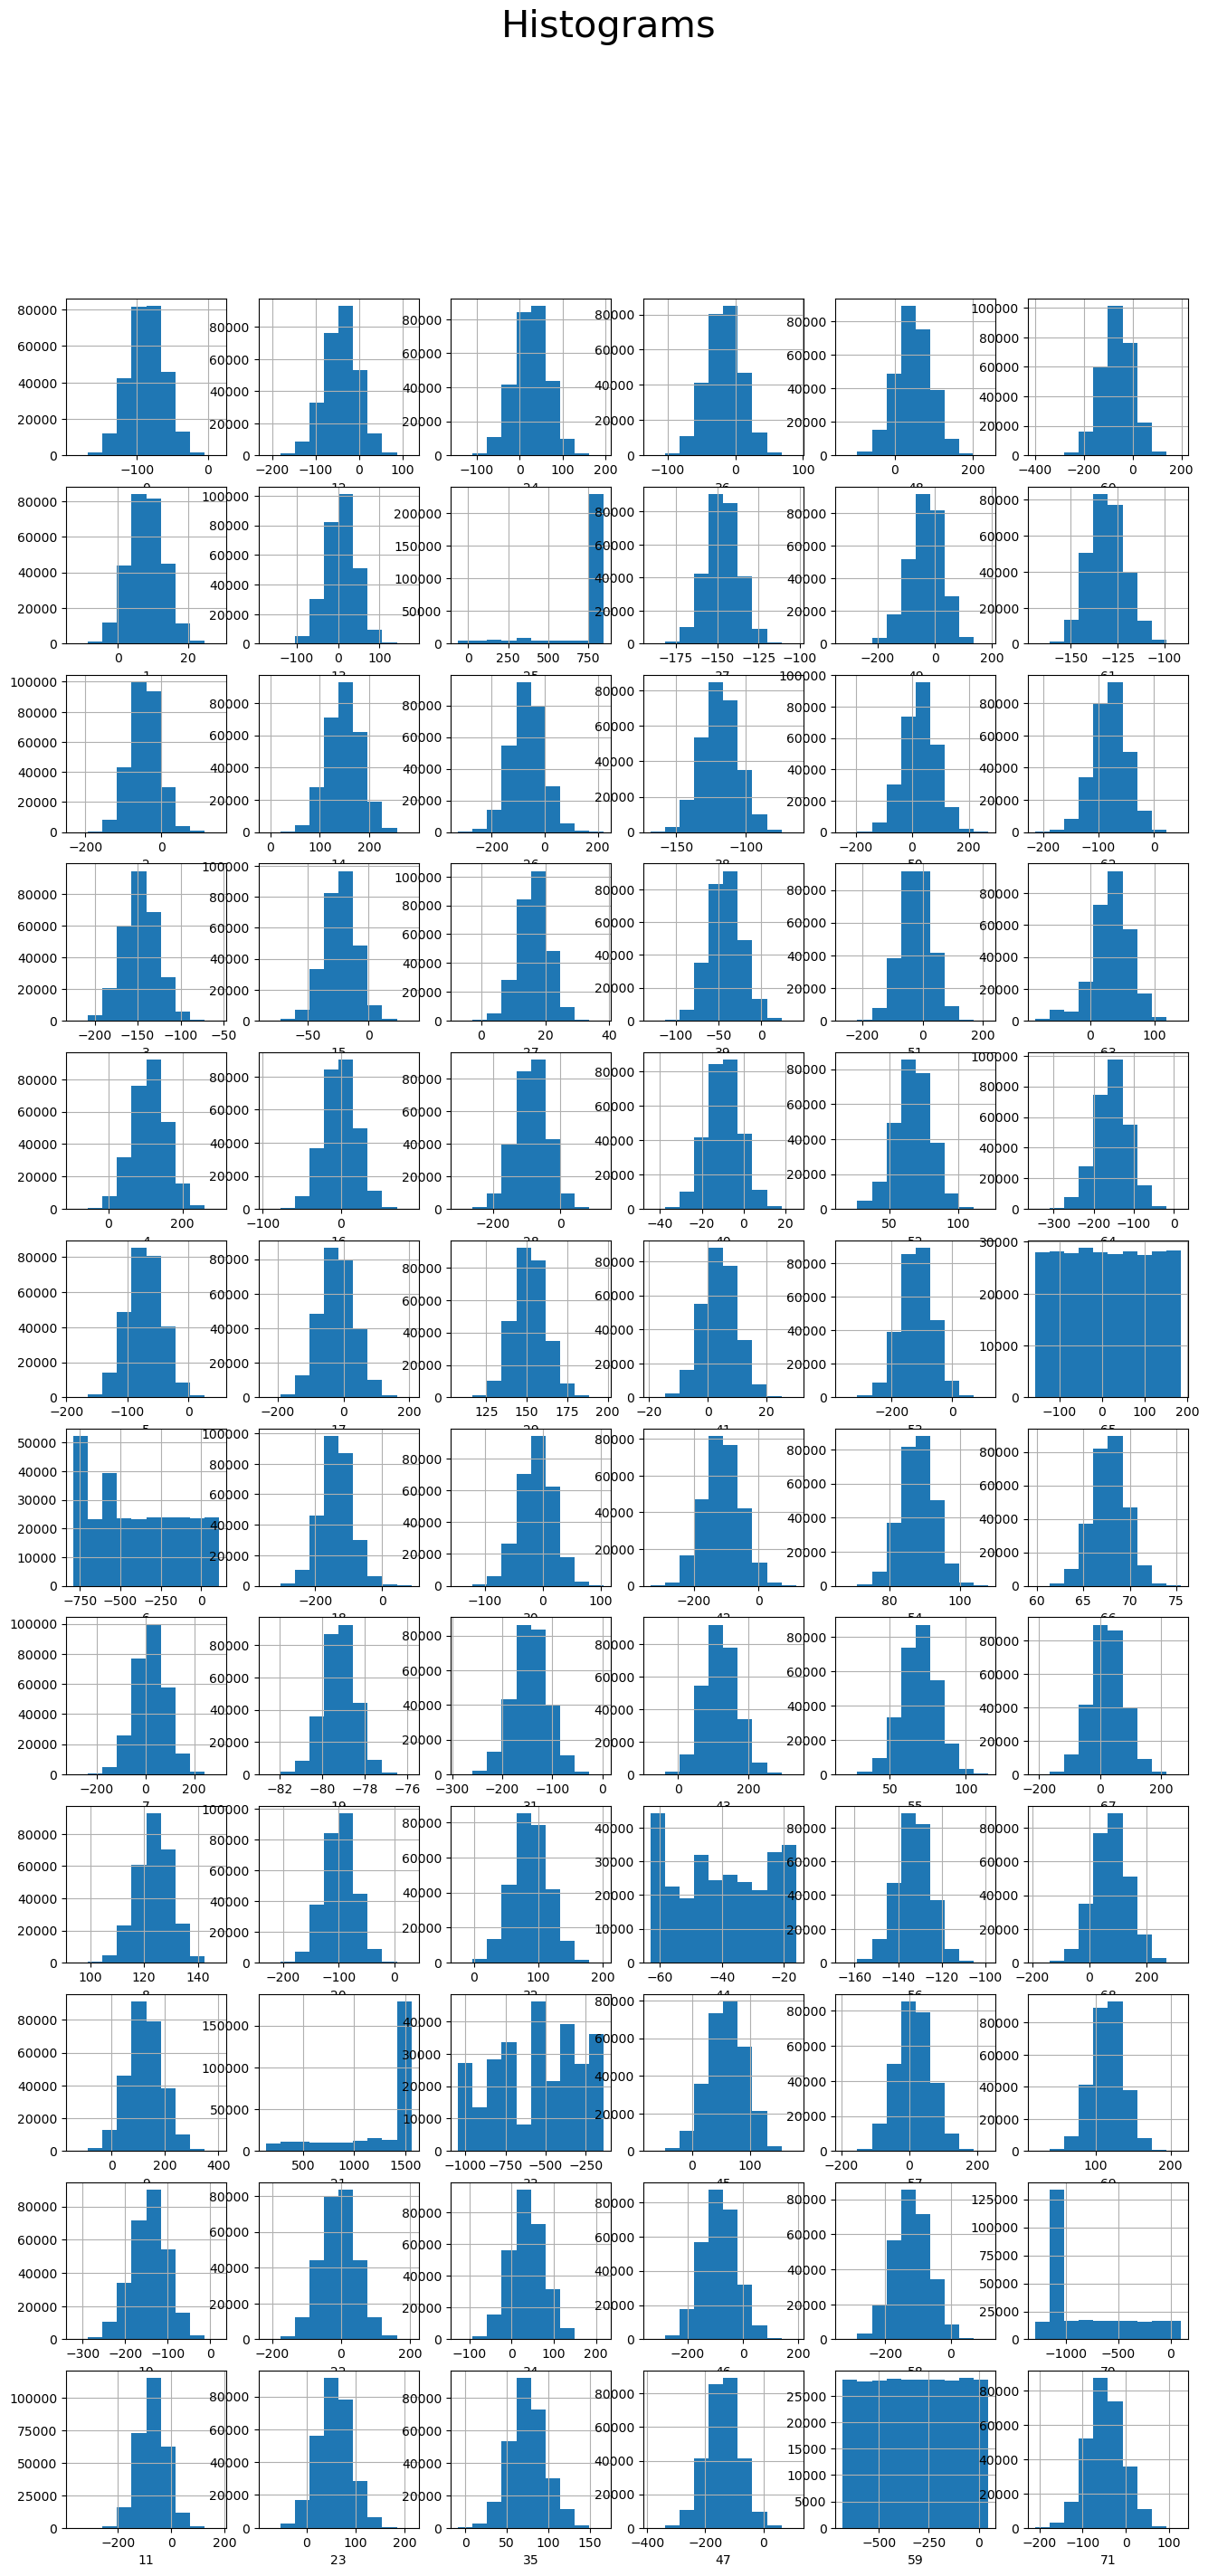

In [111]:
draw_hists(df_base, 6, 12, "Histograms")

In [129]:
df_base[cols].corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,-0.016743,0.028459,-0.018786,0.041322,-0.029705,0.002445,-0.003435,-0.002241,-0.004894,0.026850,0.010495,-0.020648,-0.024236,0.020849,-0.015815
1,-0.016743,1.000000,0.002496,0.007540,-0.020812,0.031544,0.012104,0.045660,0.002970,-0.037749,-0.073242,-0.031237,-0.015443,0.028595,-0.054362,0.063397
2,0.028459,0.002496,1.000000,0.000950,0.003621,-0.050753,-0.000210,0.027713,0.003669,0.001391,0.010223,-0.015002,-0.024433,0.018444,-0.012672,0.012508
3,-0.018786,0.007540,0.000950,1.000000,-0.005130,-0.003709,0.000313,0.001591,-0.015072,-0.009471,0.025398,-0.009972,-0.016732,-0.011602,0.017011,-0.003335
4,0.041322,-0.020812,0.003621,-0.005130,1.000000,0.014090,0.006696,-0.013910,-0.002692,0.016043,0.012677,-0.032732,0.006689,0.014261,0.002949,-0.027991
5,-0.029705,0.031544,-0.050753,-0.003709,0.014090,1.000000,-0.007756,0.003115,-0.014309,0.006888,-0.068225,-0.020791,0.003907,0.004122,-0.002387,0.079524
6,0.002445,0.012104,-0.000210,0.000313,0.006696,-0.007756,1.000000,-0.013146,0.019791,-0.016035,-0.016240,-0.002292,0.000981,-0.003419,0.000833,0.035307
7,-0.003435,0.045660,0.027713,0.001591,-0.013910,0.003115,-0.013146,1.000000,-0.001732,-0.033667,-0.042167,0.032059,-0.006806,0.028115,-0.028331,0.028986
8,-0.002241,0.002970,0.003669,-0.015072,-0.002692,-0.014309,0.019791,-0.001732,1.000000,0.026357,-0.030565,0.021250,-0.018789,0.029159,-0.010254,0.056953
9,-0.004894,-0.037749,0.001391,-0.009471,0.016043,0.006888,-0.016035,-0.033667,0.026357,1.000000,-0.013309,-0.014162,0.014835,-0.019668,0.008849,-0.022909


In [125]:
interval_cols = list(df_base.columns)
interval_cols.remove('Id')
cols = interval_cols[:16]
cols

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15']

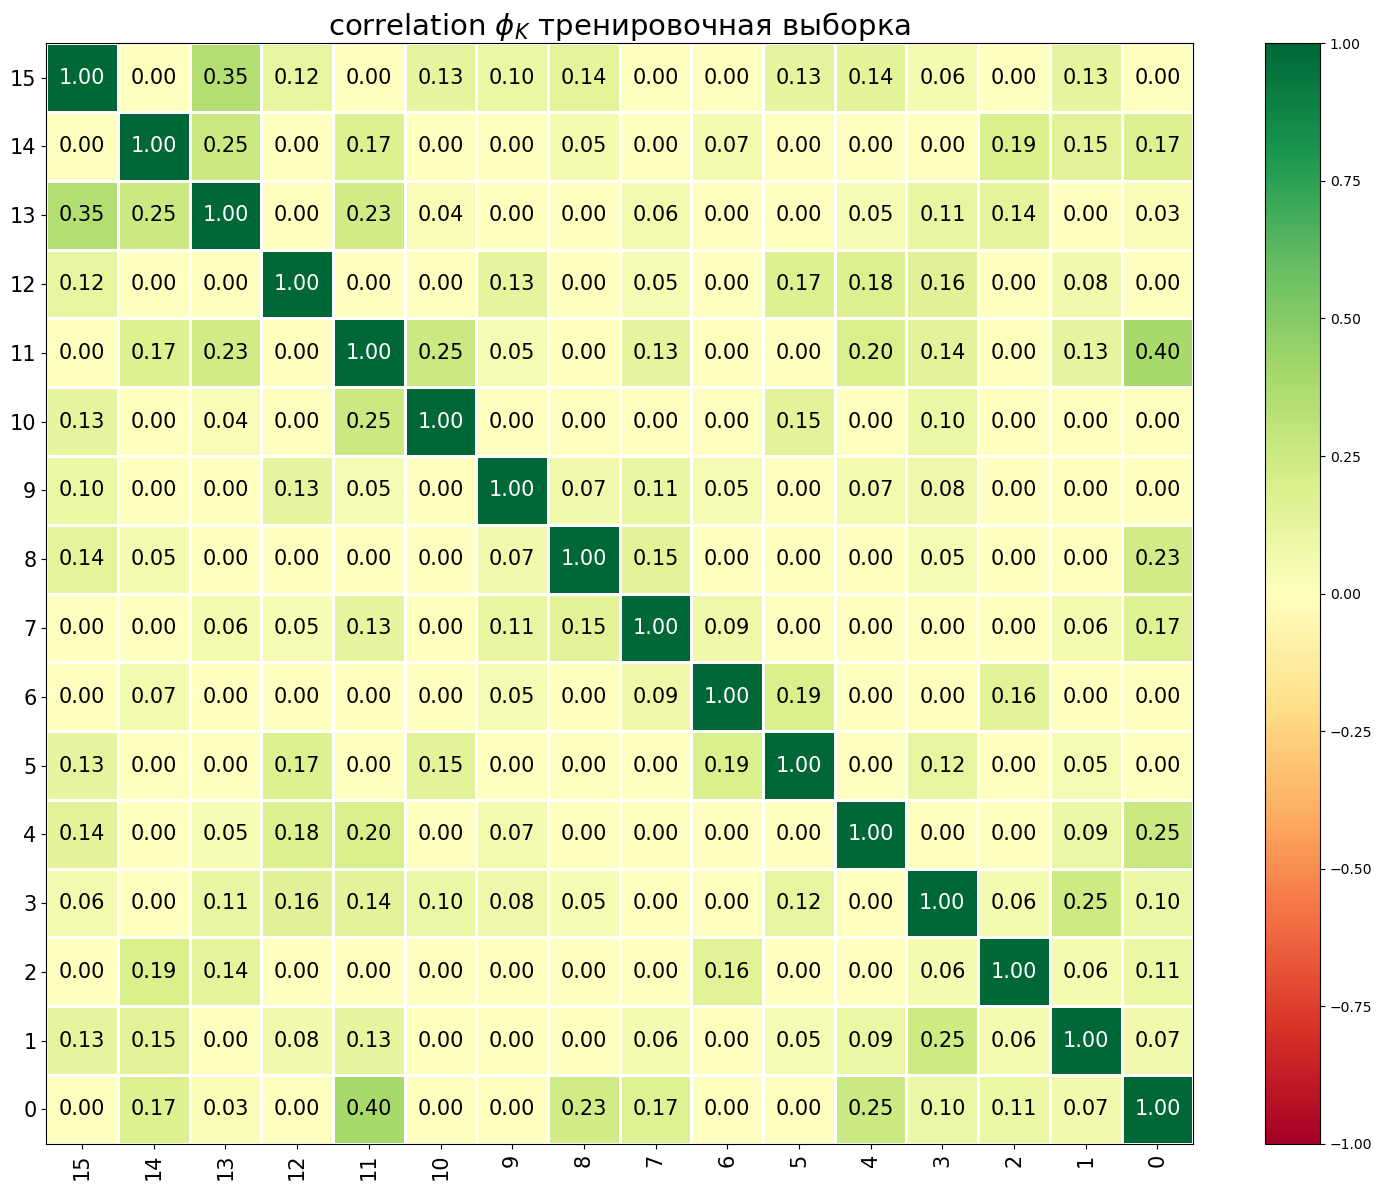

In [127]:
phik_overview = df_base[cols].sample(1000).phik_matrix(
    interval_cols=cols
)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$ тренировочная выборка",
    fontsize_factor=1.5,
    figsize=(15, 12)
);